# Multi-layer (Deep) Artifical Neural Network (ANN)

In [20]:
#setting up enivorment
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt

In [5]:
#1 Load in Data
df = pd.read_csv("wallacecommunications.csv")
TARGET = "new_contract_this_campaign"

X = df.drop(columns=[TARGET, "ID"], errors="ignore")
y = df[TARGET]

# If target is strings like yes/no, convert to 0/1
if y.dtype == "object":
    y = y.astype(str).str.lower().map({"yes": 1, "no": 0, "y": 1, "n": 0, "true": 1, "false": 0})
y = y.astype(int)


In [6]:
#2 train/val/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)  # 0.25 * 0.80 = 0.20


In [7]:
# 3 Preprocessing
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # min_frequency groups rare categories -> fewer columns -> faster/less memory
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=20, sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

In [8]:
#4 Model in the pipeline
mlp = MLPClassifier(
    random_state=42,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", mlp)
])

In [14]:
#5 Hyperparameter tuning
param_dist = {
    "model__hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    "model__activation": ["relu", "tanh"],
    "model__alpha": [1e-5, 1e-4, 1e-3, 1e-2],             # L2 regularisation
    "model__learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3],
    "model__batch_size": [128, 256, 512],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=1,
    verbose=1,
    error_score="raise"
)

In [15]:
from time import perf_counter
import joblib

t0 = perf_counter()
search.fit(X_train, y_train)
pd.DataFrame(search.cv_results_).to_csv("ANN_cv_results.csv", index=False)
joblib.dump(search.best_estimator_, "best_ANN_pipeline.joblib")
t1 = perf_counter()

print(f"Seconds for 3*15 = 75 fits:", t1 - t0)
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Seconds for 3*15 = 75 fits: 779.3916597999923
Best params: {'model__learning_rate_init': 0.001, 'model__hidden_layer_sizes': (64, 32), 'model__batch_size': 256, 'model__alpha': 1e-05, 'model__activation': 'relu'}
Best CV ROC-AUC: 0.7857715913103633


In [26]:
# 6 Validate
best_mlp = search.best_estimator_
val_proba = best_mlp.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)
prec, rec, thr = precision_recall_curve(y_val, val_proba)


val_proba = best_mlp.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)

f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1[:-1])
chosen_t = thr[best_idx]

print("Chosen threshold (max F1):", chosen_t)
print("Val precision:", prec[best_idx], "Val recall:", rec[best_idx])

#print("\nValidation ROC-AUC:", roc_auc_score(y_val, val_proba))
#print("\nValidation report:\n", classification_report(y_val, val_pred, digits=3))


Chosen threshold (max F1): 0.3006423741299956
Val precision: 0.6216505894962486 Val recall: 0.5858585858585859


In [28]:
#7 Final test evulationion with refit on train + val
best_mlp.fit(X_trainval, y_trainval)

test_proba = best_mlp.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= chosen_t).astype(int)
#test_pred = (test_proba >= 0.5).astype(int)

print("\nTEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print("\nTEST report:\n", classification_report(y_test, test_pred, digits=3))


TEST ROC-AUC: 0.7937025721460899

TEST report:
               precision    recall  f1-score   support

           0      0.890     0.899     0.894      8153
           1      0.566     0.544     0.555      1980

    accuracy                          0.829     10133
   macro avg      0.728     0.722     0.725     10133
weighted avg      0.827     0.829     0.828     10133


In [29]:
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

[[7326  827]
 [ 902 1078]]
              precision    recall  f1-score   support

           0      0.890     0.899     0.894      8153
           1      0.566     0.544     0.555      1980

    accuracy                          0.829     10133
   macro avg      0.728     0.722     0.725     10133
weighted avg      0.827     0.829     0.828     10133


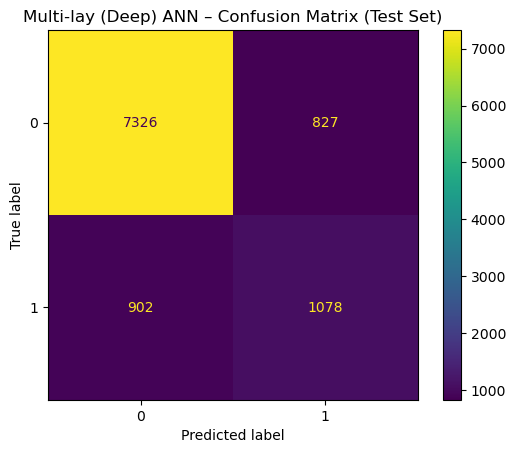

In [31]:
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format="d")
plt.title("Multi-lay (Deep) ANN – Confusion Matrix (Test Set)")
plt.show()

In [42]:


val_proba = best_mlp.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)

target_precision = 0.75
min_recall = 0.20   # adjust (e.g., 0.20 or 0.30)

valid = np.where((prec[:-1] >= target_precision) & (rec[:-1] >= min_recall))[0]

if len(valid) == 0:
    # fallback: pick best F1 if constraints impossible
    f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = np.argmax(f1[:-1])
    chosen_t = thr[best_idx]
    print("No threshold met constraints; fallback to max F1.")
    print("Chosen threshold:", chosen_t, "Val precision:", prec[best_idx], "Val recall:", rec[best_idx])
else:
    # among valid thresholds, take the highest precision (or highest threshold)
    best_idx = valid[np.argmax(prec[valid])]
    chosen_t = thr[best_idx]
    print("Chosen threshold (precision≥target and recall≥min):", chosen_t)
    print("Val precision:", prec[best_idx], "Val recall:", rec[best_idx])


Chosen threshold (precision≥target and recall≥min): 0.7154928626189441
Val precision: 0.8594890510948905 Val recall: 0.23787878787878788


In [47]:
#Option B 7 Final test evulationion with refit on train + val
best_mlp.fit(X_trainval, y_trainval)

test_proba = best_mlp.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= chosen_t).astype(int)
#test_pred = (test_proba >= 0.5).astype(int)

In [49]:
print("\nTEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))


TEST ROC-AUC: 0.7937025721460899
[[8023  130]
 [1580  400]]
              precision    recall  f1-score   support

           0      0.835     0.984     0.904      8153
           1      0.755     0.202     0.319      1980

    accuracy                          0.831     10133
   macro avg      0.795     0.593     0.611     10133
weighted avg      0.820     0.831     0.789     10133


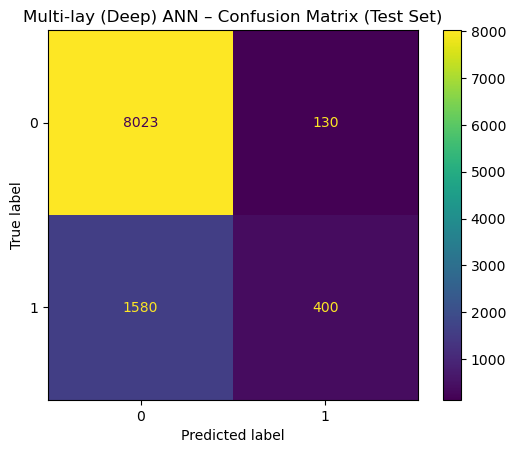

In [50]:
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format="d")
plt.title("Multi-lay (Deep) ANN – Confusion Matrix (Test Set)")
plt.show()